<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/4.EI_20_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
P_max = 30 #in dBm

In [2]:
var = 20
number_of_cells = 4

In [3]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:

In [4]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-09-22 08:03:39--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-09-22 08:03:39--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc354a0845c5d1da9f480599f19f.dl.dropboxusercontent.com/cd/0/inline/BWoHsokP6RDTtPdbGudqDFm57rmdBmLPn05QAAs_CnWif1-q1FbSDvisBhowKNm2SnFeUEgpWfp0UbnRikjCN4yFwNDmkrC6AqsQkoE9T-1rBq1ETaYgAct0Xef36D1azEkHJLLc2n_oaXUvdB22Uonz/file# [following]
--2021-09-22 08:03:40--  https://uc354a0845c5d1da9f480599f19f.dl.dr

In [5]:
!wget https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
!wget https://www.dropbox.com/s/52gyqiq137mo2bb/SE.mat

--2021-09-22 08:03:45--  https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utf73kdk09gjvsu/RR.mat [following]
--2021-09-22 08:03:46--  https://www.dropbox.com/s/raw/utf73kdk09gjvsu/RR.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b80e98a0d70ac500cff352631.dl.dropboxusercontent.com/cd/0/inline/BWrRKE0wgW4xYo6A8AztUaKaolbKxeqccIMb5c-YzGewuiSnmzakSI2GLsvkhjnt_WRAS_9V_yvbc7TelEspkIHfh0YqFslZjmexwsksYmhLLe2QDL6TDOv9iX-hMIsy7n3BDW8BFNw2lmptADg9NCu-/file# [following]
--2021-09-22 08:03:46--  https://uc5b80e98a0d70ac500cff352631.dl.dropboxusercontent.com/cd/0/inline/BWrRKE0wgW4xYo6A8AztUaKaolbKxeqccIMb5c-YzGewuiSnmzakSI2GLsvkhjnt_WRAS_9V_yvbc7TelEspkIHfh0YqFslZjmexwsksYmhL

In [6]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [9]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [10]:
def EIacquisition(Xsamples, X, model):
  Xsamples = Xsamples[np.newaxis,:]
  yhat, _ = surrogate(model, X)
  best = max(yhat)
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = 0
  probs = (mu - best - sigma) * norm.cdf((mu - best - sigma)/(std+1e-10)) + std * norm.pdf((mu - best - sigma)/(std+1e-10))
  return -probs[0]

In [11]:
#optimize the acquisition function
def opt_acquisition(X, y, model):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  
  for i in range(1):
    result = dual_annealing(EIacquisition, bounds, args=(X,model))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [12]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [14]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP_EI.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP_EI.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP_EI.npy")

In [15]:
print(y)

[[26.33129267]
 [31.13153327]
 [38.79989131]
 [41.83712256]
 [24.29160657]
 [33.05435195]
 [41.26676818]
 [41.16335755]
 [22.45473026]
 [35.15233069]
 [45.04911557]
 [45.04869863]
 [48.53342826]
 [50.4143532 ]
 [47.57108437]
 [18.51683028]
 [50.85935992]
 [51.96807877]
 [51.25271584]
 [50.00799287]
 [51.23312094]
 [51.96778075]
 [51.87488472]
 [51.74952817]
 [50.31904845]
 [54.37045807]
 [53.85015376]
 [52.99859112]
 [50.95935435]
 [54.44375003]
 [53.57013046]
 [54.51497582]
 [51.52692869]
 [54.49364859]
 [55.01021954]
 [51.29411124]
 [53.80983264]
 [53.6084904 ]
 [53.92873284]
 [54.34106362]
 [54.97022485]
 [54.95124178]
 [52.24593741]
 [54.95138349]
 [54.95117233]
 [54.95108568]
 [54.95105904]
 [54.80625996]
 [54.95113151]
 [57.9908654 ]
 [55.05410425]
 [54.4845721 ]
 [58.51465156]
 [58.58270696]
 [54.25559009]
 [51.76618695]
 [56.00075028]
 [55.6618143 ]
 [57.22071813]
 [55.54510203]
 [55.10546438]
 [56.41411191]
 [54.06791749]
 [56.47604295]
 [55.09852006]
 [55.65906443]
 [56.97342

x_next is [ 30.          30.          29.9998645   29.99984562  29.99999999
  30.          30.          29.99999977  29.99996929  14.80517391
 -30.99966873  29.99999982  29.99999985  29.99999975  29.99999998
  29.99999997  30.          29.99999993  29.99978889  29.9999131 ]
f()=59.443972, actual=60.015
0


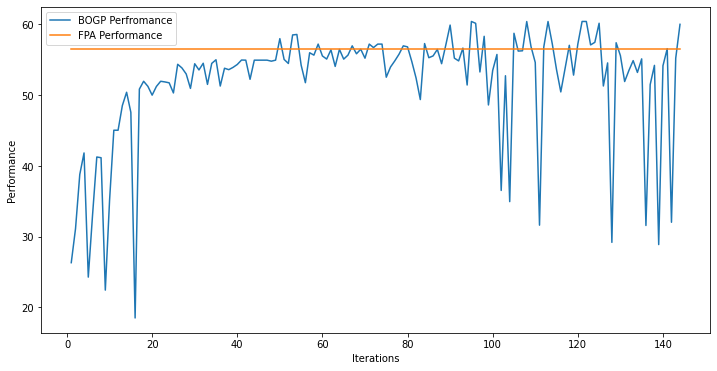

x_next is [ 29.95945538  29.95510869 -30.95455295   1.82632539  29.99283589
  29.98416064 -30.92363158  29.99431989  29.94542626 -30.98074225
 -30.92827737  29.98699444  29.9391225   29.96954796 -30.97302709
  29.99633214   7.81722646  29.98517352  29.99306467  29.98522342]
f()=54.551256, actual=51.861
1


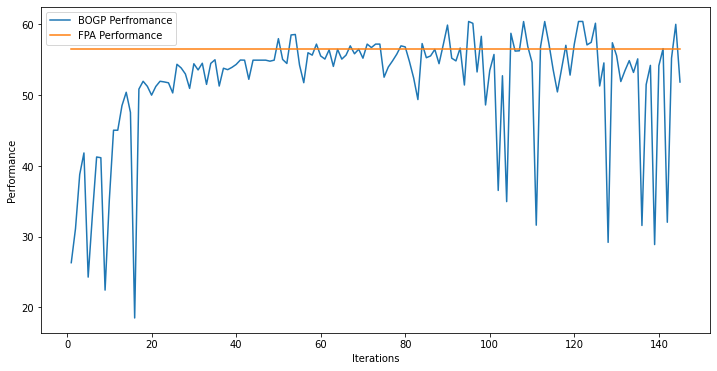

x_next is [ 30.          29.99999999  29.99999986  30.          30.
  30.          29.99999999  30.         -30.99977846  -6.11448808
 -30.99994847  29.99999998  29.99999999  29.99999996 -30.99995107
  29.99999999  29.99999997  30.          30.          29.99999999]
f()=57.327834, actual=56.187
2


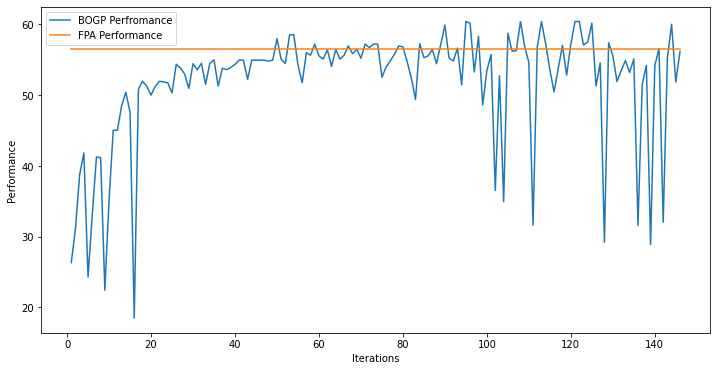

x_next is [ 29.99999997  29.99948294  29.99999998  29.99999997  29.99991979
  29.99999996  29.99999996  29.99999997  29.99999997  14.44245068
 -30.99997108  30.          29.99999997  29.99999997  29.99999999
  29.99999999  29.99999997  29.99999998  29.99991803  29.99999998]
f()=59.498910, actual=59.955
3


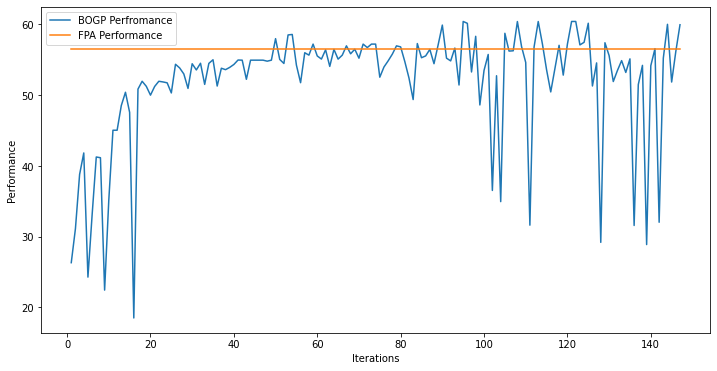

x_next is [ 29.91125733  29.82768808  29.81234085   6.03998004  29.97731313
  29.98082659  29.81198028  29.93775567 -30.71392776   3.52364103
  10.48719143  29.88085786  29.91454156  29.97301294  29.90483469
  29.94403853  29.93382495  29.93936689  29.94785214  29.99741143]
f()=56.304552, actual=57.013
4


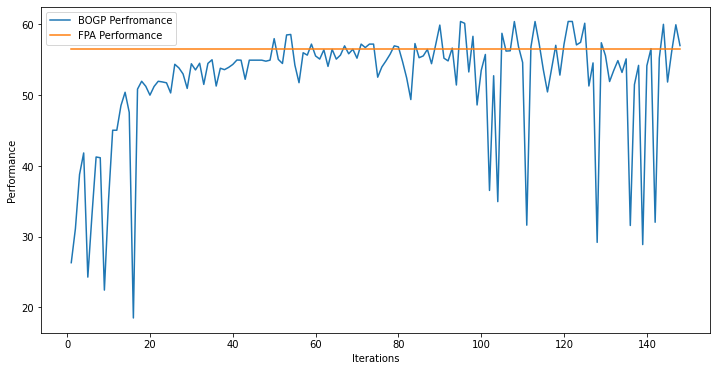

x_next is [ 29.97775701  29.96277922  29.84112392  20.29944074  29.98119237
  29.97363067  29.97653399 -30.73752001  29.8539596  -12.06213643
  28.31390763  29.95075452  29.99353256  29.9804028   29.84554384
  29.9363462   29.84146917  29.96070706  29.9779785  -17.60799712]
f()=53.404956, actual=53.652
5


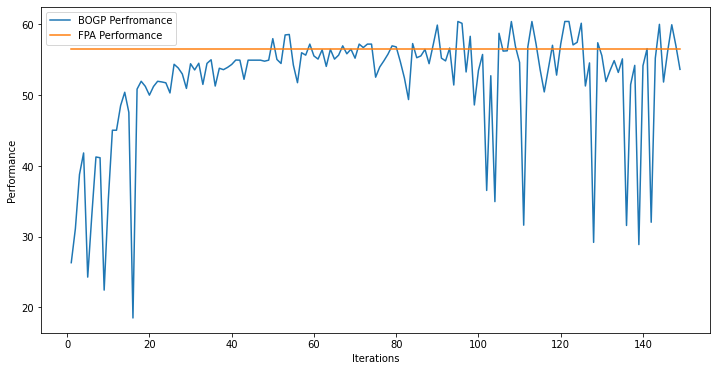

x_next is [-21.67425686  17.40297461 -24.66354808  -0.78290361  11.12883692
  20.82906453   7.93242977  20.67259813 -24.40226765   9.77601787
  10.19375543  29.18853381 -19.53390082   8.79142307  13.34233223
   5.42960971  27.88165483  22.25649069  -1.7939235   -2.54257181]
f()=52.022851, actual=37.392
6


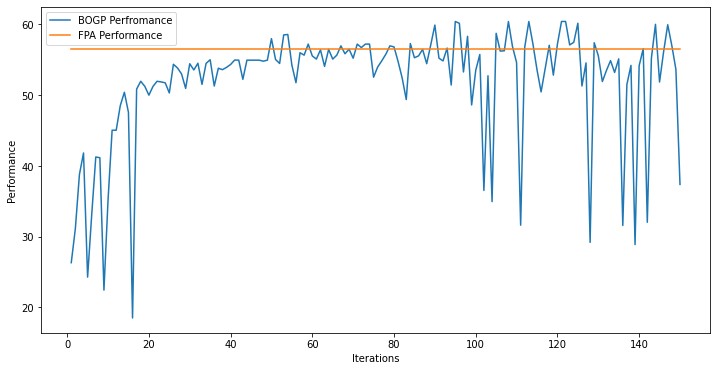

x_next is [ 29.94740156 -10.85971766  -5.95373757  19.33738241  29.98900344
  29.98018854 -30.97397442  29.92230639  29.89201161 -10.18570589
  29.83301669  29.78491206  29.9389049   29.91974945  29.99425967
  29.9897608   29.94224912  29.94751062  29.94743568  29.97918996]
f()=53.832657, actual=55.691
7


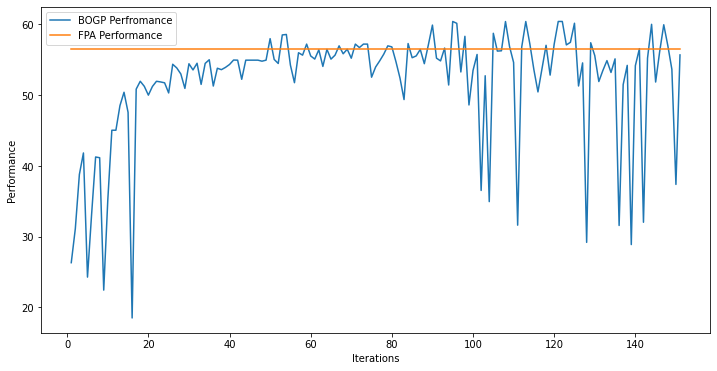

x_next is [ 29.99013979  29.9494022  -10.6831258   23.65312113  29.98847089
  29.99551603 -30.95545955  29.94532047  29.96214371  17.12412271
  29.99041567 -11.0894563   29.95167093  29.97820307  29.85755117
  29.96000711  29.99160537  29.97916698  29.9877831   29.90857836]
f()=55.994129, actual=59.380
8


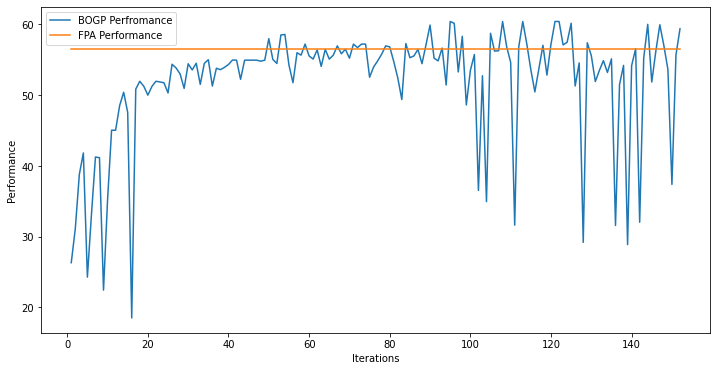

x_next is [ 29.97227379  29.97866292 -19.89521726  24.29261953  29.98758646
  29.99770834 -30.96729792   3.95244063  29.87965791  12.83983921
  29.99297561  29.68667524  29.97145383  29.95606971  29.98223426
  29.98598681  29.83382545  29.99346387  29.97557549  29.9710966 ]
f()=57.413724, actual=57.412
9


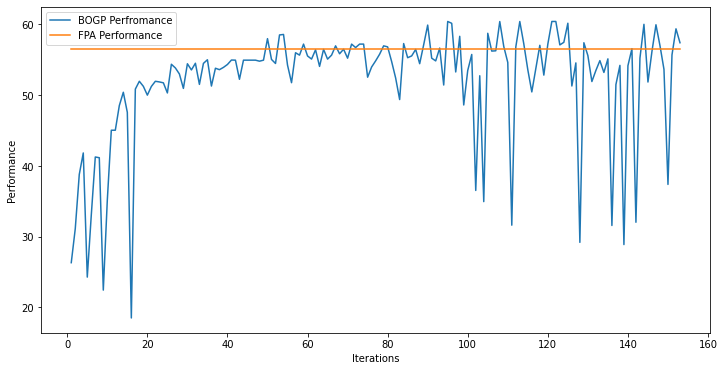

x_next is [ 29.94421958  29.97542221   0.28719147  26.81542219  29.92902583
  29.98241265 -30.87959235  29.92424491  29.98182639   3.28904265
  29.94480173  -3.91407246  29.9965983   -1.74057682  29.98522996
  29.95077434  29.94385217  29.97492863  29.94393282  29.9738352 ]
f()=57.396813, actual=54.610
10


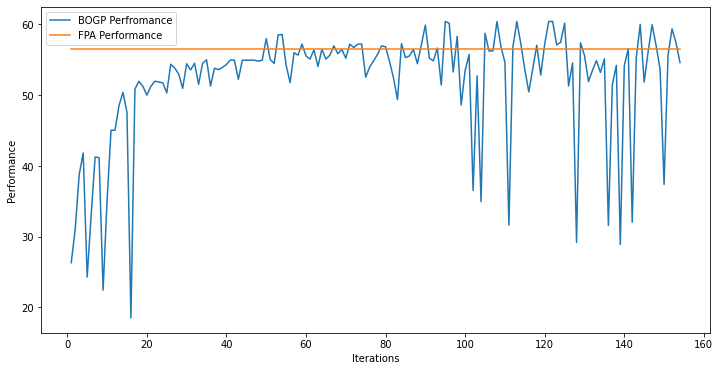

x_next is [ 29.97954655  29.96644818 -24.68916305  11.16383623  29.9898848
  29.99021265  -0.98052774  29.97501525   1.94702226  22.15059037
  29.95798298 -30.9880513   29.97056588  29.97195651  29.99529216
  29.97486303  29.91868001  29.97413036  29.99946157  29.95102939]
f()=56.022316, actual=57.049
11


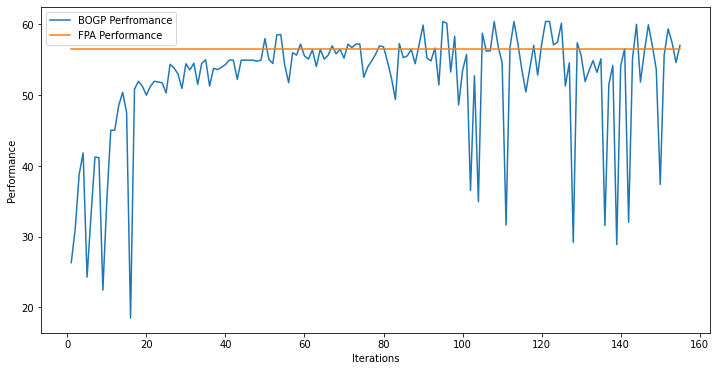

x_next is [ 29.97304346  29.96466871   8.94831304  -8.42859956  29.99262122
  29.99401809 -30.96181324  29.92330778  29.86923821  21.49015639
  29.99321582  -7.86544875  29.99590652  29.99512635  29.98999379
  29.9798387   29.92266339  29.98557653  29.97400163  29.98908175]
f()=57.385258, actual=55.969
12


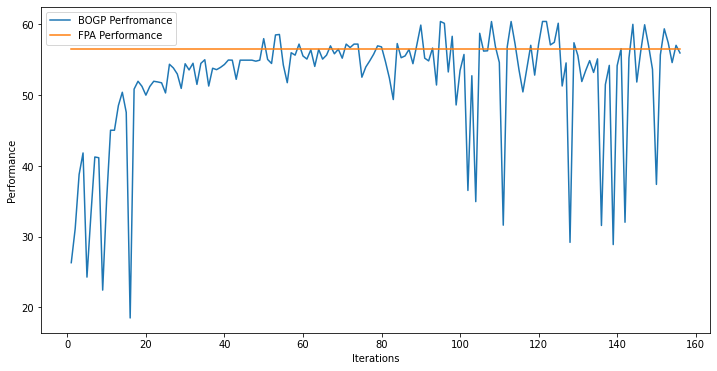

x_next is [ 29.99926781  29.98523234  -8.45611626  29.94757522  29.96785712
  29.98874144 -19.17309918  29.93892745  29.98748648  15.78412374
  29.94657172 -30.98397902  29.9675594   29.97896635  -7.80505061
  29.98007205  29.93254951  29.98205201  29.9838408   29.99168388]
f()=57.117724, actual=57.013
13


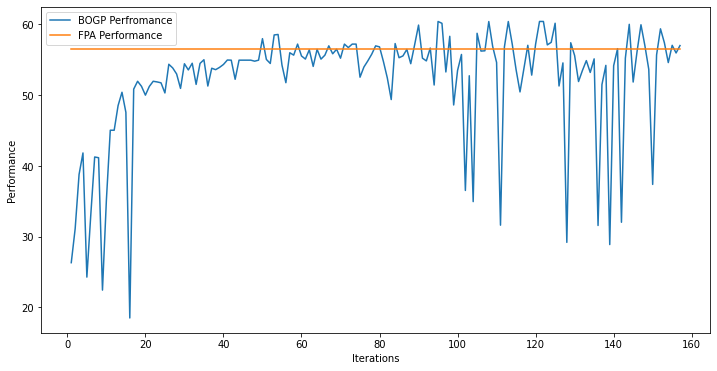

x_next is [ 29.96814875  29.99999721 -19.57240462  26.63049345  29.99736267
  29.98869383 -30.98014543  29.99488496   5.77376356  21.0265512
  -5.72774835 -19.69494491  29.97256188  29.98175988  29.99015663
  29.98636259  29.77183339  29.99886387  29.97017446  29.92625848]
f()=57.162136, actual=58.450
14


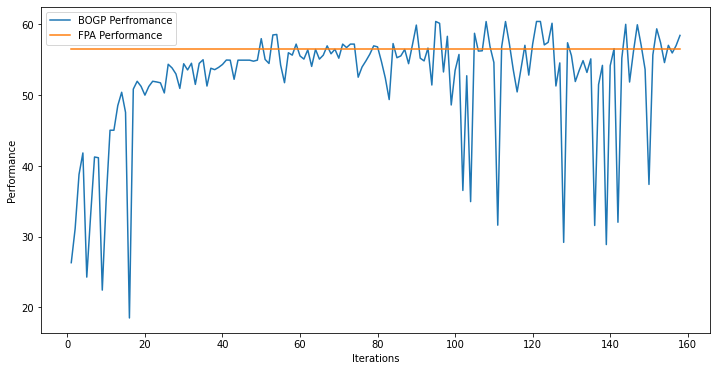

x_next is [ 29.98424656  29.72435471  29.58614259  15.29678987  29.87174569
  29.96222094  29.91314128  29.91309074  -0.90303552   5.82140307
 -30.9862071   29.9168923   29.87249375  29.98133508  29.9929143
  29.98795159  29.99882771  29.98216004   9.01789524  29.94680977]
f()=58.819237, actual=58.368
15


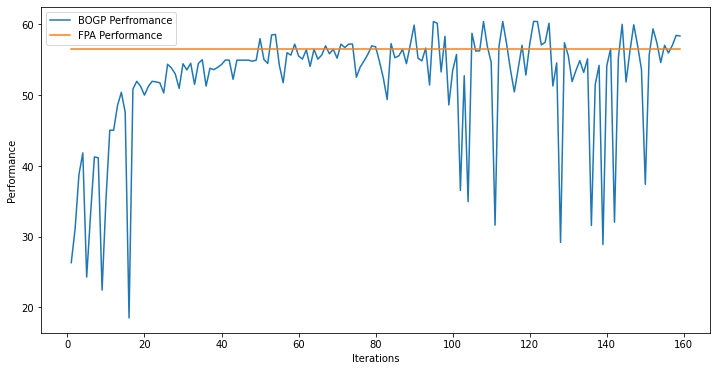

x_next is [ 29.9724403   29.99057445  -8.22328698  29.96525853  29.9672736
  29.98737013 -30.72189227  29.98842327  28.84593065  11.92417663
  26.67478697  -8.43704496  29.99872761  29.99618403  29.99074907
  29.98293474  29.93830898  -8.85114981  29.99311641  29.97272619]
f()=54.973810, actual=53.977
16


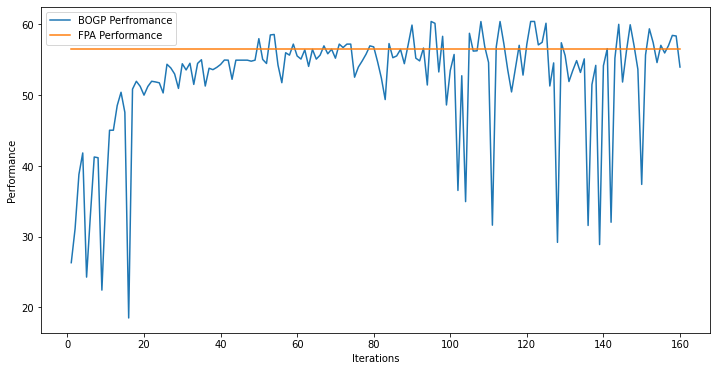

x_next is [ 29.97909943  29.90770273  29.78821262   6.8771743   29.97873176
  29.97968058  29.95326238  29.94215998 -30.75518441   2.67339217
 -30.95770702  29.96088826  29.94537698  29.95862096  29.91543877
  29.98734683  29.99575522  29.97871761  29.94700946  -3.26192642]
f()=56.325289, actual=53.822
17


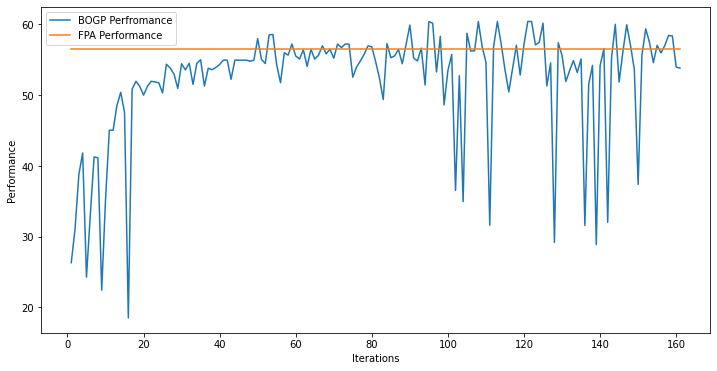

x_next is [ 29.94320861  29.98937204 -20.58585341  28.02584836  29.95599134
  29.99037389 -30.84525398  29.9420034   -6.49368288  26.47365919
  26.6846515   19.38326631  29.93037815  29.99749273  11.11083063
  29.95922035  29.89869703  29.99316122  29.94710566  29.99352311]
f()=56.935997, actual=55.907
18


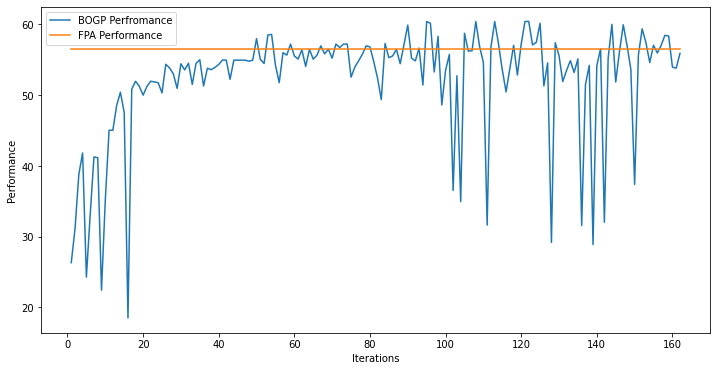

x_next is [-10.82252746  -5.9210433   13.31080834   5.426713   -15.35125443
  12.47386082 -29.56271187  -8.65742751  24.75311462  -1.74575043
   0.41586442  27.8535407   26.54206044  27.66981473  23.97632746
  10.16578541  20.76692641  -6.95143096 -15.04315272 -11.28432494]
f()=52.262330, actual=35.359
19


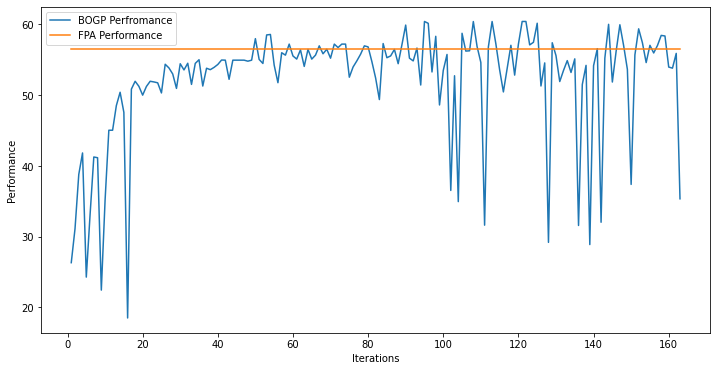

x_next is [ 29.98344744  29.85181545 -30.95932192   6.99544392  29.96181905
  29.99107405  29.99521946  29.92299295  29.97950212 -30.90003907
 -30.99840327  29.9786603   29.96994574  29.98899389  29.96092834
 -24.2550417   29.99422438  29.98593566  29.98066611  29.97795732]
f()=54.641736, actual=54.796
20


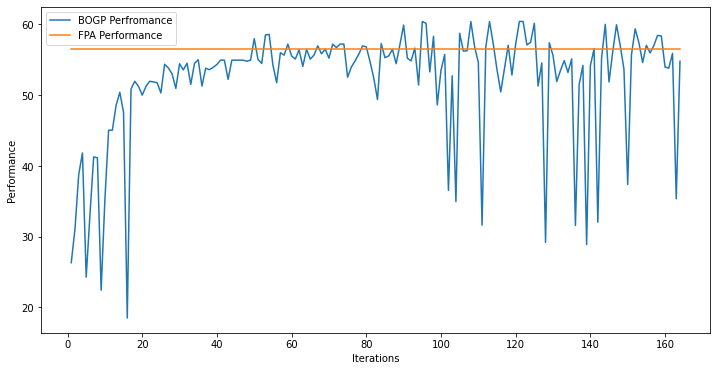

x_next is [ 29.99667614  29.96721123 -14.63725399  29.80844476  29.95754564
  29.97755927  29.99552809  29.98263514 -15.0413339  -29.71361113
  29.99870602 -30.97959331  29.9921307   29.9774229   29.99103134
  29.97054856  29.95794814  29.98129409  29.98647918  29.95899619]
f()=54.934261, actual=55.903
21


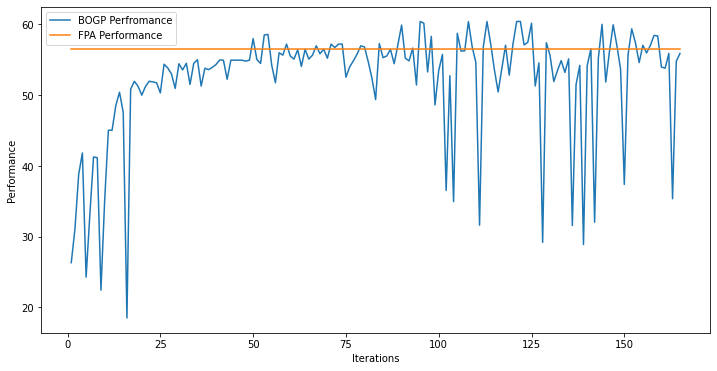

x_next is [ 29.94661391  29.92980599 -30.6625058   22.42967795  29.99791074
  29.97910256  29.90222402 -19.61147421 -29.2426053   -6.13979412
  29.97569075  29.96372077  29.99172262  29.91611166  29.98593005
  29.98951268  29.9805109   29.99577298  29.98626352  29.98284929]
f()=53.885229, actual=56.709
22


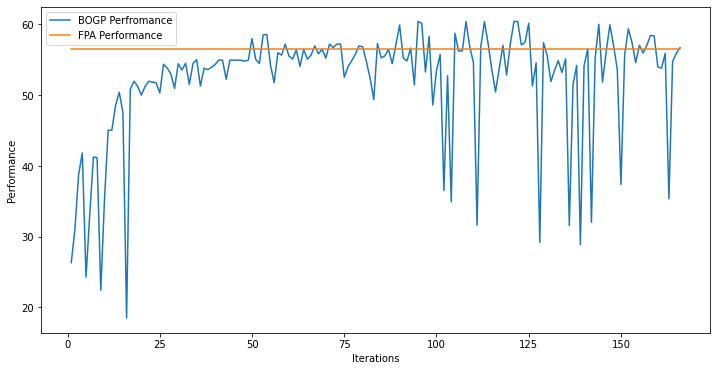

x_next is [ -8.35272003  29.98034418  -2.78034384  25.96205358  29.99710847
  29.98484824  29.94324683  -9.35868549   2.2304681  -20.38637329
  29.96418252  29.97281502  29.962981    29.93258554  29.92622233
  29.93084692  29.9922189   29.98213823  29.99375438  29.96593714]
f()=55.003293, actual=52.772
23


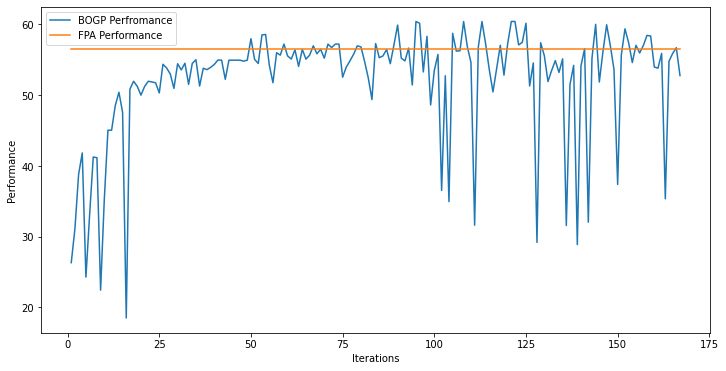

x_next is [ 29.97920898  29.97724662 -30.99788299  11.68831654  29.99748216
  29.99407668  29.97767273  29.97739564 -30.92459297  13.8381357
 -30.96947414  29.93519555  29.90998422  29.97737747  29.93218378
  29.97133525  29.96162183  29.98811897  29.99126709  29.98974029]
f()=55.624740, actual=59.575
24


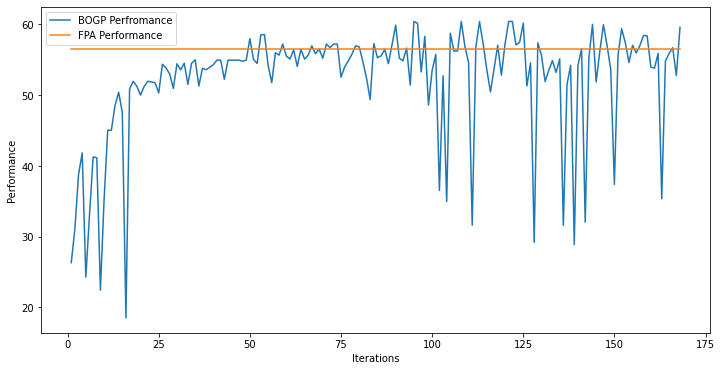

x_next is [ 20.05095023 -18.88133613  -8.63069173 -21.66351066 -16.1051858
   4.8146932   17.64576746 -30.20246227   7.47755587   0.73127749
  20.55619032   7.8918096    8.35813053  16.79334446  11.65980797
   2.5662549   27.26709756   5.69930114  -7.3582785   29.27087447]
f()=52.271508, actual=34.189
25


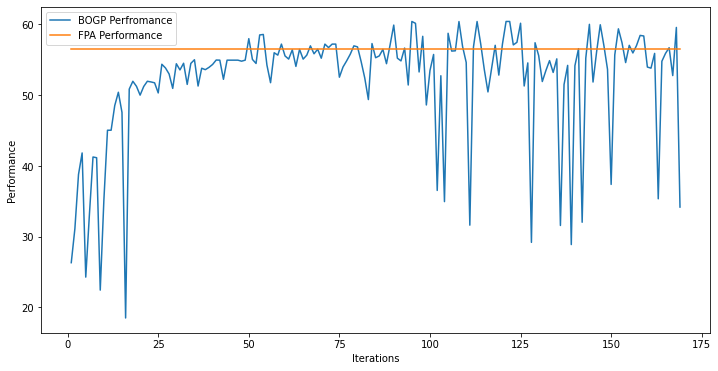

x_next is [ 30.          30.         -30.99999997  30.          30.
  29.99999999  29.99999997  30.          -7.77738648  24.57306612
 -30.99998047  29.99999999  30.          30.          29.99999997
  30.          29.99999999  30.          29.99999999  29.99999998]
f()=58.929256, actual=58.816
26


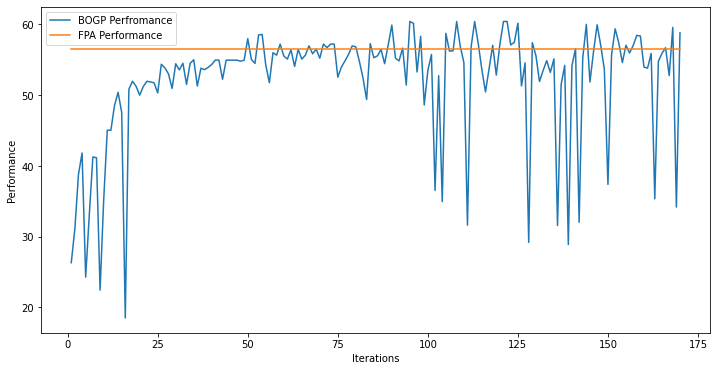

x_next is [ 29.97712623  29.91501205 -10.79731331  29.98818988  29.99125144
  29.99766843  -9.19052057  -2.26440225  29.83202836   8.7351084
  29.96893381 -30.6736518   29.99856297  29.98781696  29.97501751
  29.97214093  29.96482916  29.99066962  29.98321702  29.95271725]
f()=57.456143, actual=54.485
27


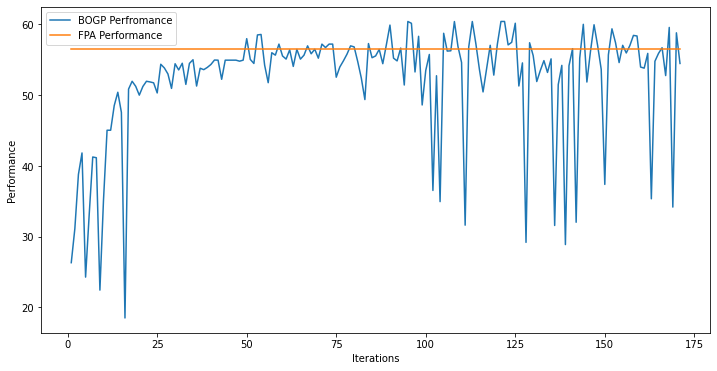

x_next is [ 11.37527623  25.52206515 -11.25996614   7.61010744  20.38306942
   9.21467345  17.23314996  23.27591993  24.09992817   1.52132769
 -15.91059742  25.61682268  13.90753987   5.31180669  -6.88515476
  19.04569863  -9.81818853  22.24065155  26.16251839   8.31003566]
f()=52.216852, actual=49.744
28


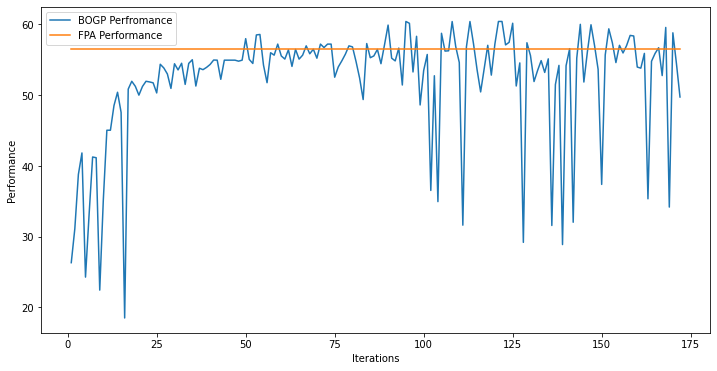

x_next is [ 29.95385017  29.98190946 -18.83482588  22.70824074  29.95974782
  29.97672324  29.90575001  29.99926776 -28.96048086  15.72748617
 -13.53724723  -2.56984799  29.9463975   29.89849919  29.96605305
  29.99431209  29.95291252  29.93248949  29.98791906  29.9811278 ]
f()=58.716390, actual=59.963
29


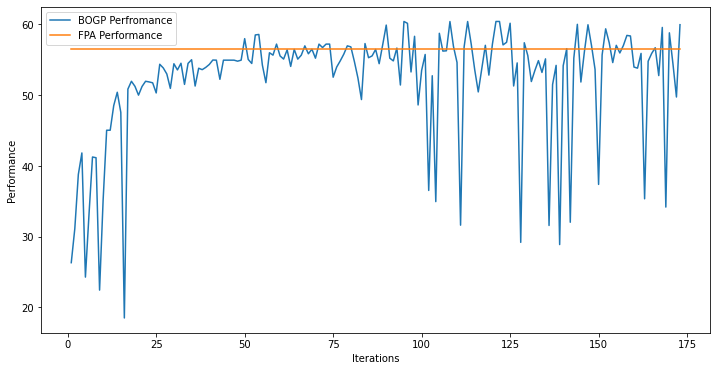

x_next is [ 29.96104764  29.98067502 -27.09746063  21.94441705  29.98542014
  29.98698711  29.99926116  29.98286014 -26.01765563  13.77444696
   6.46296549  29.89145147  29.94994344  29.91028705  29.97095938
  29.93565668  29.96628683  29.96569883  29.95105119  29.96811643]
f()=59.053331, actual=61.178
30


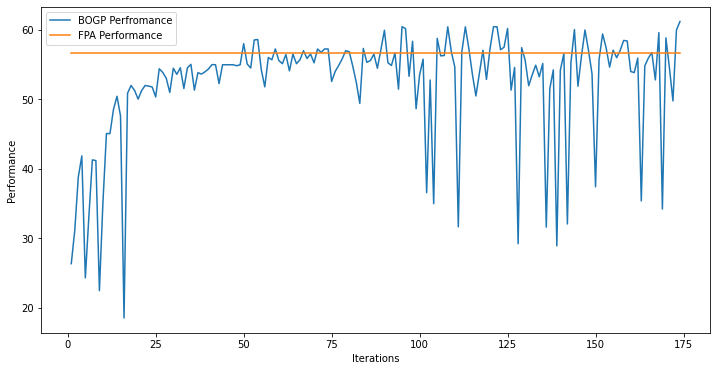

x_next is [-11.4447968   -3.18351112  10.57313651  -2.83793325 -24.08873169
  -7.29211778 -11.0076126   19.27600295 -22.09330569  25.96678325
 -21.59891179  14.91325374 -23.92587548 -25.33504786 -21.59944407
  17.3177225  -11.91625191  26.51110888   9.53532185 -28.86429764]
f()=52.298702, actual=26.555
31


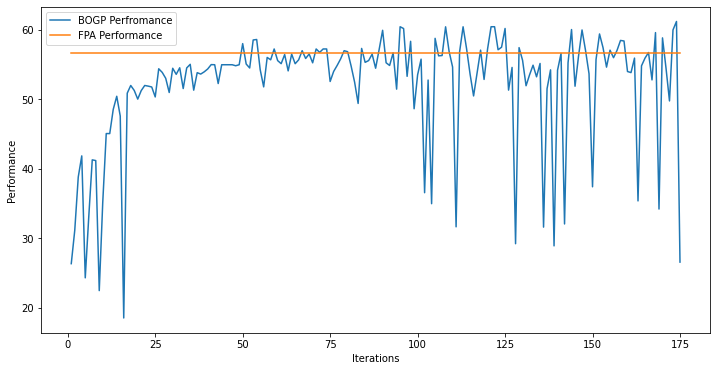

x_next is [ 30.          30.         -30.99999995  29.99999999  30.
  30.          30.          30.         -21.97606766  22.52801847
   1.79663902  30.          30.          30.          30.
  30.          30.          30.          30.          30.        ]
f()=59.943122, actual=59.405
32


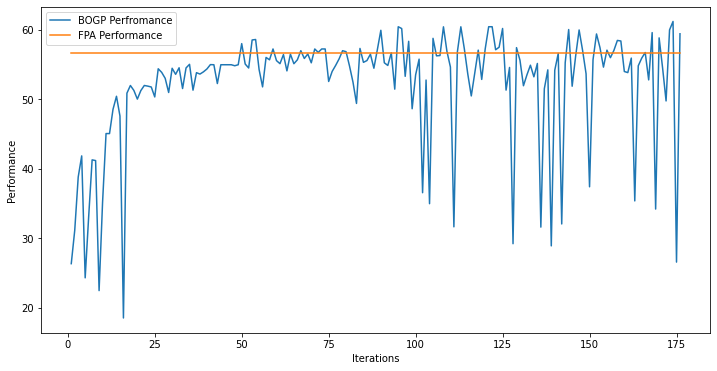

x_next is [ 29.97525399  29.96261354 -30.9867549    5.23113448  29.96903525
  29.97745566  29.95308751  29.96869144 -19.98061067   7.01277335
  14.42143419  29.72839587  29.99207812  29.95746291  29.92280429
  29.9897295   29.9084937   29.96788833  29.94943646  29.96268655]
f()=60.707042, actual=57.236
33


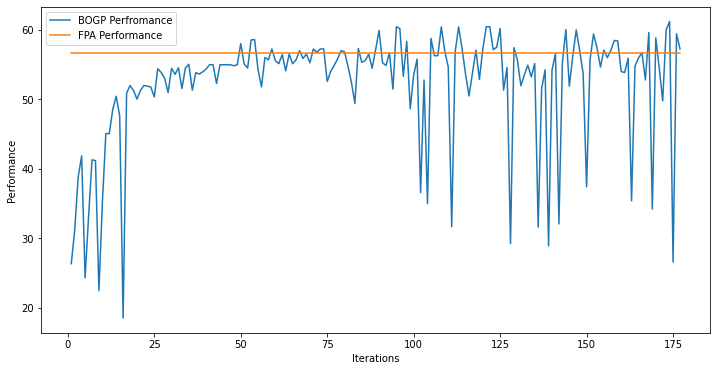

x_next is [ 29.94727562  29.96682036 -12.63416449  28.31662494  29.98950064
  29.99629044  29.96700841  29.64259598 -30.965677     5.49181396
  -1.58413595  29.99085531  29.97267137  29.99994091  29.96649539
  29.86804959  29.98642261  29.98877886  29.95316872  29.98404317]
f()=62.158910, actual=58.362
34


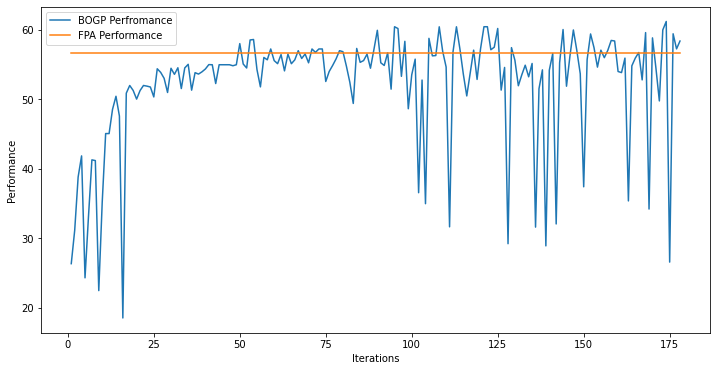

x_next is [ 27.4194582   27.86697254  28.02642952  27.959226    24.47041688
  25.8115903    9.67465124  29.97293409  24.02313877  18.30185971
 -24.18832389   5.70902048  18.14621133  20.83138866  21.99996972
   6.4282422   25.3505085   27.70784931  29.26624599  29.92639636]
f()=52.255485, actual=51.060
35


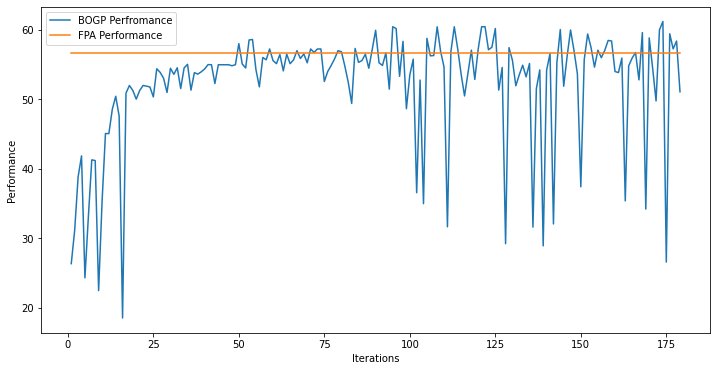

x_next is [29.71850575 29.90367459 29.63385999 29.91854601 29.84462383 29.97665131
 29.66975791 29.66806901 29.98847199 29.26452096 28.77531029 29.98681075
 29.60322592 29.68408872 29.82689843 29.91030026 29.76173763 29.92256032
 29.93200627 29.98777112]
f()=58.979862, actual=56.863
36


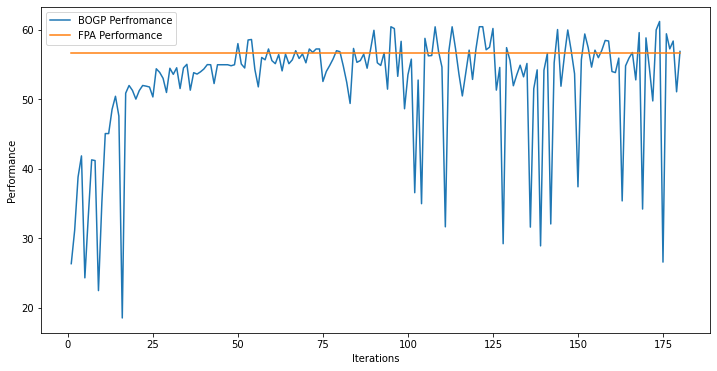

x_next is [ 21.04371199  27.27427219  11.22690235  20.87486951  28.47492512
  25.68346079 -18.93238221   0.75844566 -20.39465524  19.87275887
  -9.61714184  22.56471978  28.74583241   3.65080124  22.97810161
  10.57036571  27.95800362  19.23652027  26.97352285  -5.62999718]
f()=48.854802, actual=47.815
37


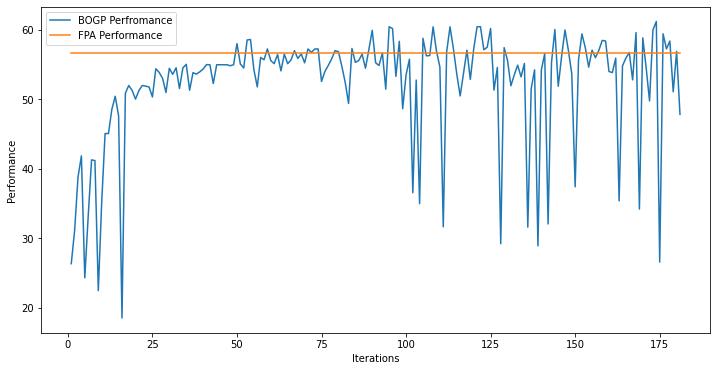

x_next is [ 30.          29.99980244 -30.9999997   29.99999999  30.
  30.          30.          30.         -28.54393735  26.68476404
 -14.20914867  29.99999998  30.          30.          30.
  29.99995837  30.          30.          30.          30.        ]
f()=59.483341, actual=57.896
38


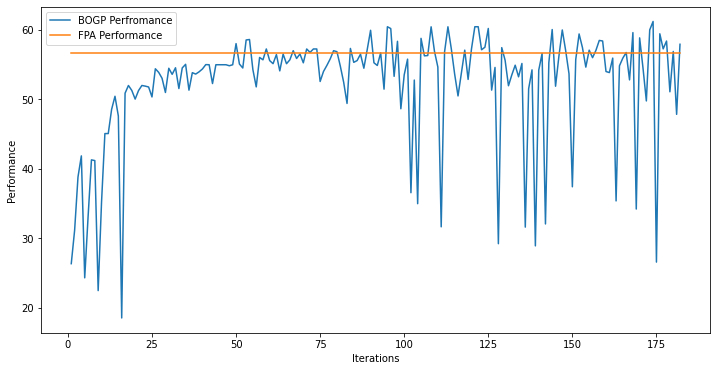

x_next is [ 29.98022563  -1.24617178 -30.96427984  13.43264694  29.95435262
  29.98291148  29.98403087  29.95004247 -16.61231631  13.87501355
 -30.98938828   7.00512787  29.99679768  29.9524287   29.97506151
  29.99416672  29.98729446  29.98242136  29.98995666  29.97742222]
f()=57.785973, actual=56.677
39


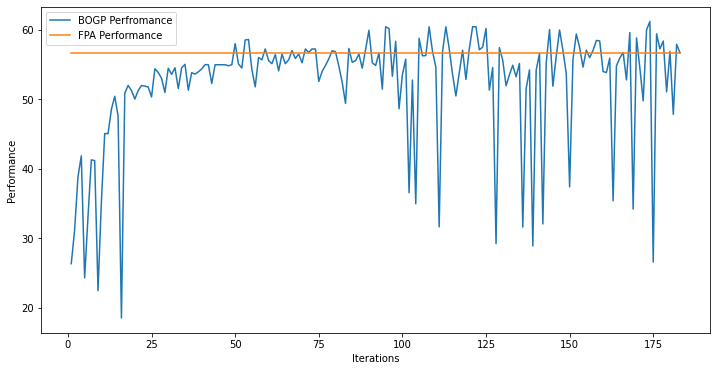

x_next is [ -0.41772033 -26.44385911 -17.80051732  18.31229332  27.41995569
  -4.56992048  26.85722598 -22.10054345   4.261851   -12.12708668
  14.9083375   22.03957153  18.41112423   8.64949989 -16.57397478
  -9.3345045   -4.42240709  -0.24192488  24.93246772  17.06391943]
f()=52.237105, actual=32.727
40


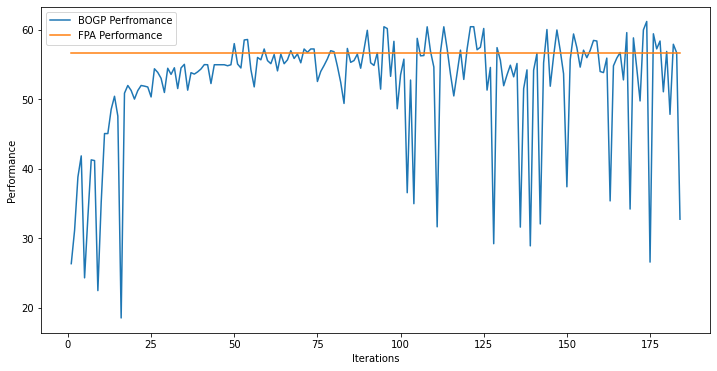

x_next is [ 29.97314506  29.99517817 -30.96354205  13.38978527  -4.04851814
  29.97919179  29.99401327  29.94799419 -13.05360501   8.24743115
 -30.95376881  29.99443872  29.98357143  29.95919211  29.93061035
  29.98837974  29.97008178  29.9981989   29.98509434  29.99262664]
f()=57.156388, actual=55.411
41


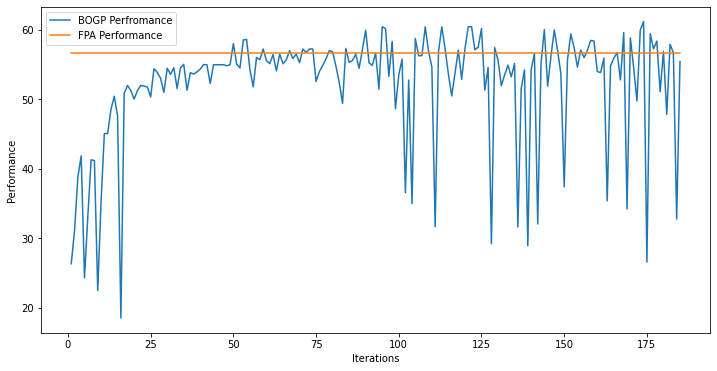

x_next is [30.         30.         30.         30.         30.         30.
 30.         30.         30.         30.         -4.28998765 30.
 30.         30.         30.         30.         30.         30.
 30.         30.        ]
f()=58.738945, actual=56.660
42


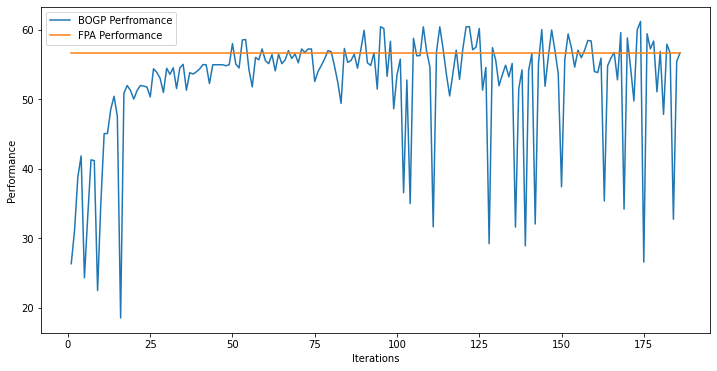

x_next is [ 29.98227563  29.99377395 -25.42201695  25.17103056  29.99518823
  29.95519803  29.86637527  29.38714624 -30.98262887  18.69918522
  19.19370604  11.98636071  29.93873654  29.96709556  29.92973125
  29.97572116  29.63514683  29.97805241  29.93494238  29.99135027]
f()=60.291266, actual=60.108
43


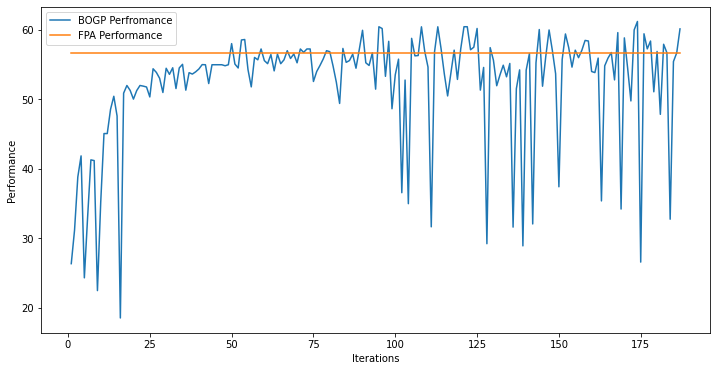

x_next is [ 29.98268933  29.90514256  29.90740288  14.81826931  29.97567712
  29.99088416  29.9693257  -30.94731065  29.90044781 -30.90623423
  29.7197072   29.98443215  29.97529707  29.9868901   29.99251209
  29.95076289  29.86265061 -20.32616083  29.99789691  29.96768235]
f()=51.482685, actual=52.645
44


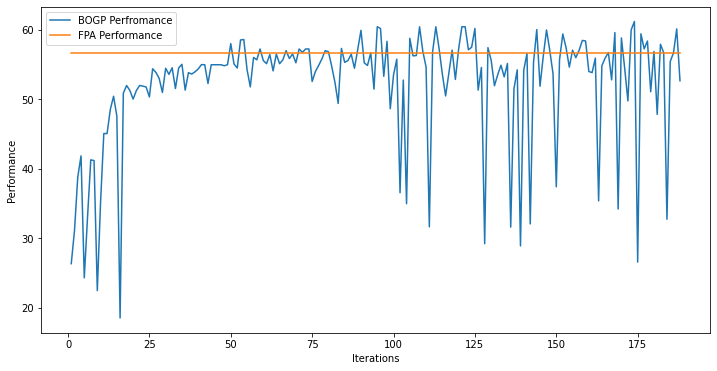

x_next is [ 30.          30.         -30.99999999  30.          30.
  30.          30.          30.         -28.80234308  22.00787392
   1.01081197  30.          30.          30.          30.
  30.          30.          30.          30.          30.        ]
f()=59.282681, actual=59.507
45


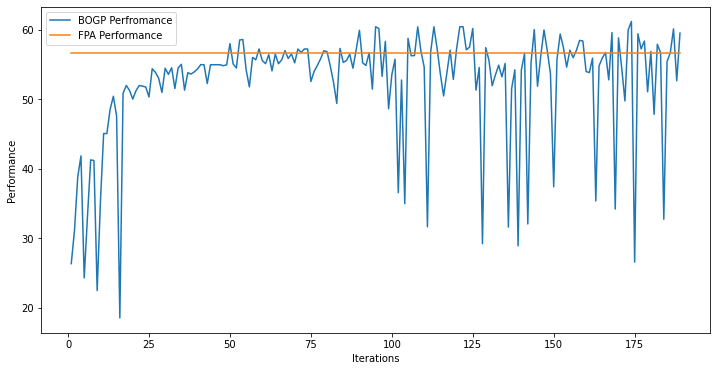

x_next is [ 29.99999984  29.99999992  29.99987042  29.9999999   29.99999984
  29.99999993  29.99999998  29.99999989  29.99999833  29.99999986
 -30.99988903  29.99999978  29.99999991  29.99974694  29.99999988
  29.99999986  29.99999967  29.99999982  29.99999979  29.99999956]
f()=57.559344, actual=56.660
46


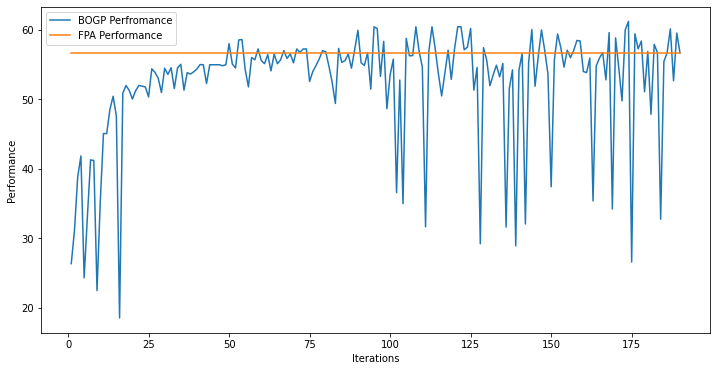

x_next is [ 29.94177837  29.95442548  -7.25991692  17.88071956  29.99977764
  29.98082033  29.91694675  29.94810258  29.84783612  18.70241549
  29.95835256  29.94792604  29.98659166  29.9782633  -30.92579906
  29.99512932   1.55318899  29.9981477   29.96214108  29.89030573]
f()=55.988704, actual=58.584
47


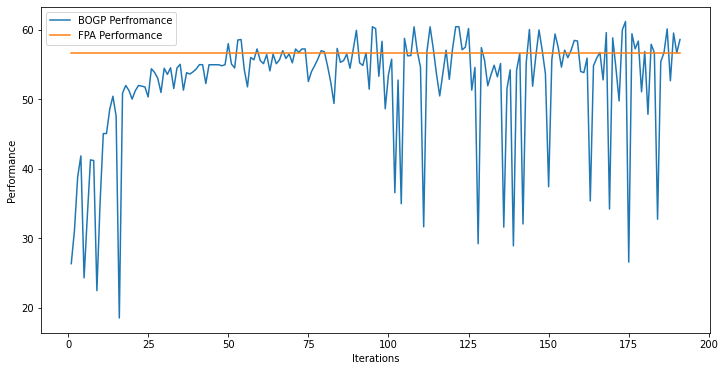

x_next is [ 29.96175196  29.98020172  -7.65456256  26.09877712  29.98524388
  29.96882424 -30.97004216  29.95441423  29.96587812  14.97428525
  13.93748179  -0.88700197  29.98049472  29.99614945  29.98807349
  29.98743992  29.97140318  29.9669462   -6.21064645  29.91090947]
f()=56.136670, actual=55.157
48


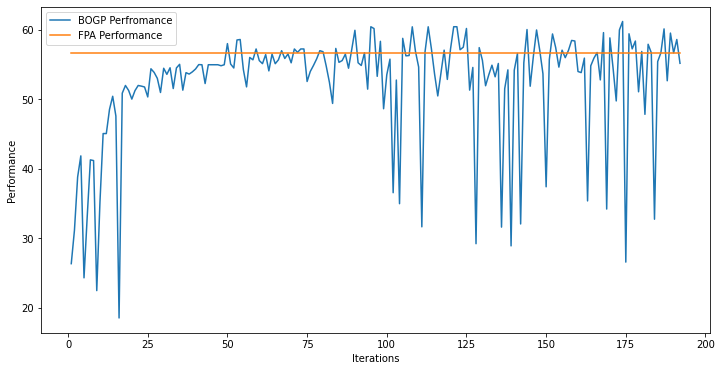

x_next is [ 29.98527647  29.99504087 -30.97247811  19.07101528  29.99449183
  29.98865312  29.95560293  29.9770981  -30.06179403  21.06956526
   1.53288212   1.00356638  29.98423357  29.91573458  29.91443001
  29.98317561  -4.70237154  29.99219171  29.95405766  29.9571927 ]
f()=57.814383, actual=57.436
49


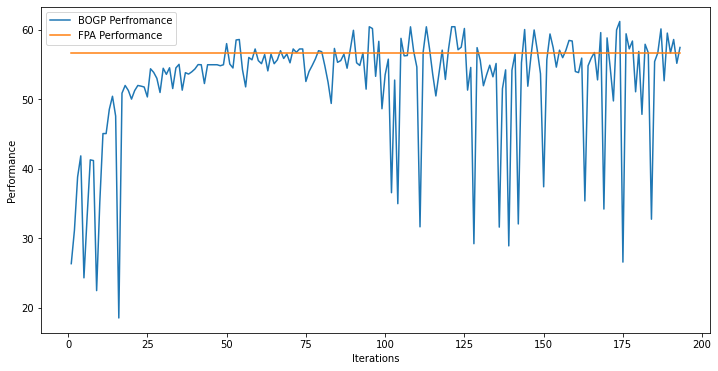

x_next is [ 29.98431846  29.98047451 -30.95730539  13.17758792  29.98095048
  29.98699511  29.95832697  29.91713808 -12.30743392  10.7204786
 -30.93318951  29.92563575  -5.63607277  29.99415042  29.91551138
  29.97736382  29.92105927  29.97017132  29.99847691  29.99955954]
f()=57.045253, actual=56.349
50


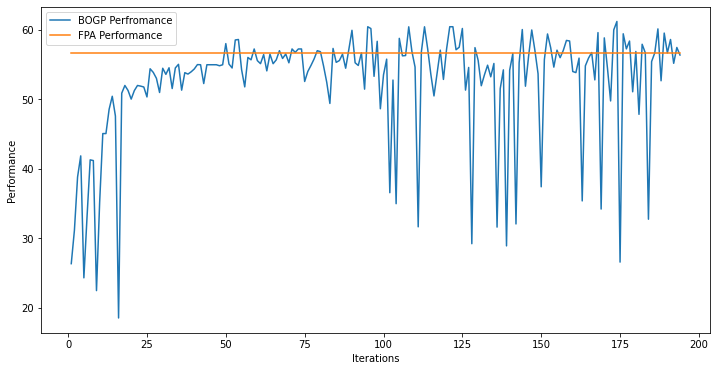

x_next is [ 30.          30.         -30.99999957  29.99999997  30.
  30.          29.99999999  30.         -22.02835375  24.41462436
   7.76904092  29.9999605   30.          30.          29.99999999
  29.99999999  29.99999999  30.          29.99999999  30.        ]
f()=59.377461, actual=58.873
51


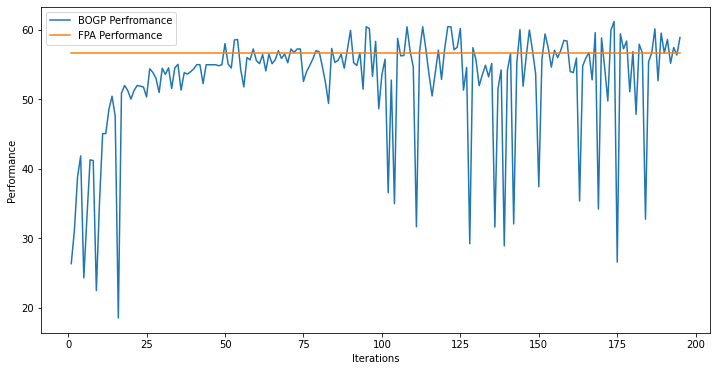

x_next is [ 29.95500348  29.96519425   8.90678913  14.21210663  29.98744235
  29.98212541  29.97018381  29.94181399  29.89638855   6.54562595
  14.34692841  29.98455596  29.96708285  -0.65636199 -30.88533679
  29.9953274   29.93566446  29.9233417   29.94433898  29.98300392]
f()=56.953819, actual=56.186
52


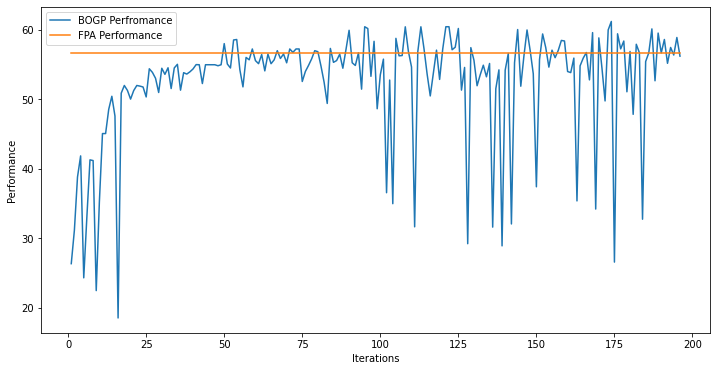

x_next is [ 29.90411387  29.96665832 -30.99811892  20.82890366  29.95058184
  29.99717724  29.96314819  23.09693066 -27.85603006  12.21969426
   1.67810508  18.39589773  29.94604867  29.90418994  29.61725157
  29.98812764  29.97901248  29.92588265  29.99990419  29.96565364]
f()=61.134274, actual=58.577
53


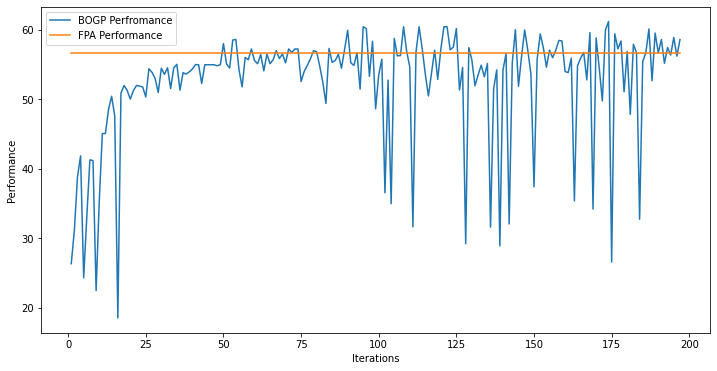

x_next is [ 29.91853786  29.97198461 -12.93547384  29.93657228  29.98778561
  29.96928083  29.95515989  29.99326888  29.63421813  22.78629725
  29.94020255 -30.90052756  29.99876659  29.99225429  29.92607482
  29.99817526 -17.02392126  29.97848883  29.97662093  29.90300108]
f()=55.798633, actual=56.648
54


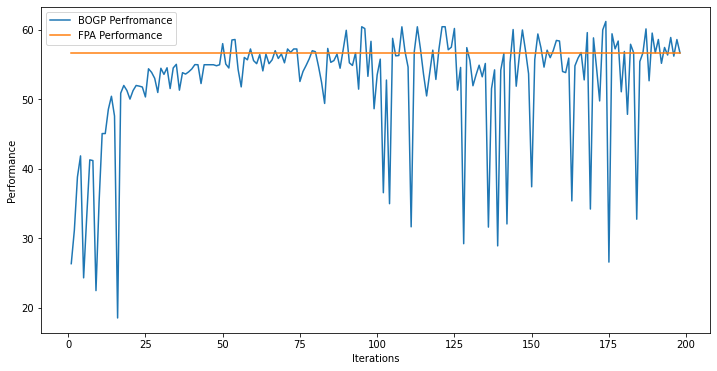

x_next is [ -5.69482472   9.44618956  19.60338169  25.44977828 -28.95897796
 -22.28992678 -14.30356662   1.4753852  -29.29422232   0.2024933
 -12.05368214  20.66941887 -14.19252991   7.1677937   -1.26109054
  28.99010383  22.96297059  -6.05214618  -0.36101327  -4.30323987]
f()=52.542289, actual=26.533
55


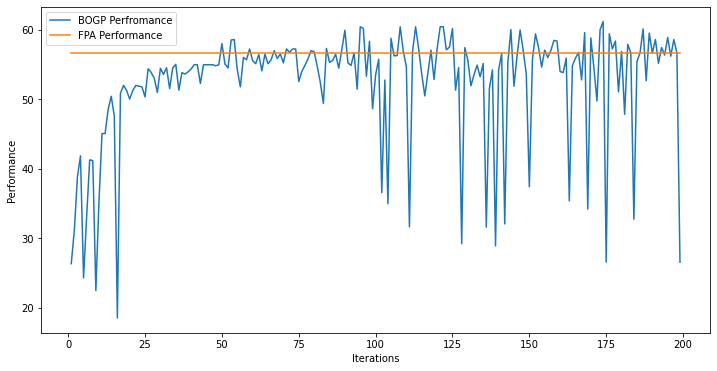

x_next is [ 29.9706841   29.95727708 -15.32562962  22.02005865  29.97991167
  29.97122218  29.96469567  29.98820466 -30.98863369  13.65477475
  29.96678543  29.94227361  29.94619686  29.91825161 -14.41424969
  29.97929241  29.74176504  29.98707941  29.95052452  29.90867202]
f()=57.342501, actual=60.417
56


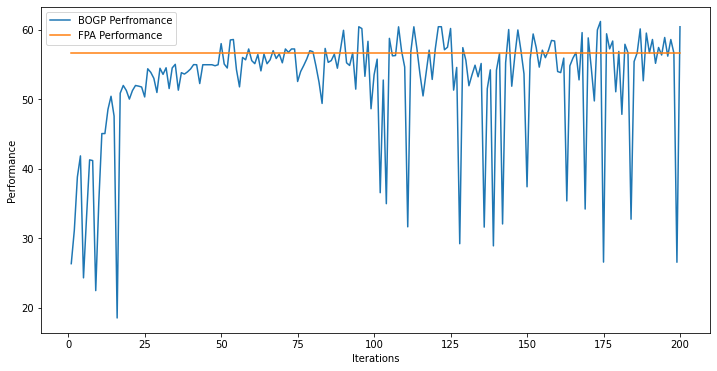

x_next is [ 30.          30.         -30.99990459  29.99999986  30.
  30.          29.99999999  30.         -30.99999987  28.00078329
  29.99999997  29.99999996  30.          30.          17.06164441
  30.          30.          30.          30.          30.        ]
f()=59.460997, actual=56.456
57


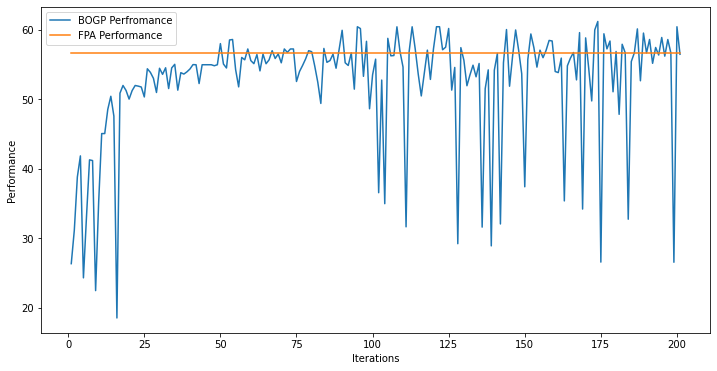

x_next is [ 29.94551197  29.98784612 -20.13003206  14.84113525  29.98362627
  29.9880684   29.98263391  29.99971466 -30.99910817  25.1125137
   6.45366082 -30.20331741  29.94656663  29.98511419 -30.95895984
  29.98842835  29.83562111  29.99299931  29.92628893  29.97899208]
f()=56.270404, actual=57.200
58


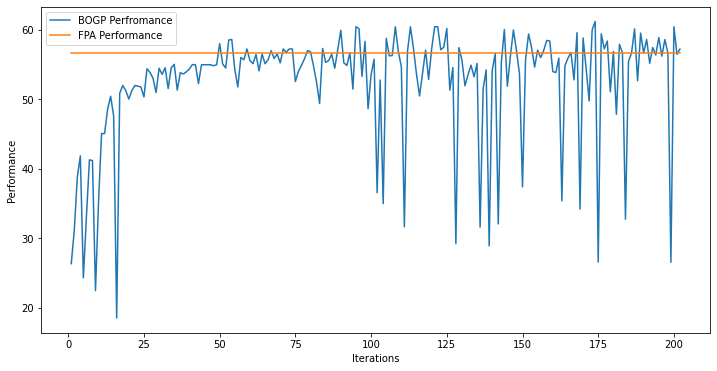

x_next is [ 30.          30.         -28.75018716  29.99999986  30.
  30.          30.          30.         -16.41108572  17.4116523
  -7.90605438  29.99999999  30.          30.          29.99999995
  30.          30.          30.          30.          30.        ]
f()=59.192019, actual=59.674
59


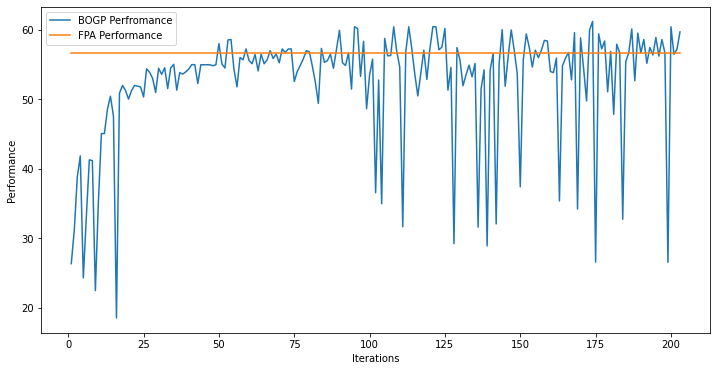

x_next is [ -8.72097919  -5.23893414 -14.1589769    0.67313387   1.9024234
 -30.15566789 -11.83574874 -26.2037838  -15.67074643  20.89525678
 -17.11153125 -20.92238935  20.0182578   19.82631144 -27.65779347
  25.06954214 -17.93474848  -5.74181256 -28.76440685 -15.8621306 ]
f()=52.530080, actual=21.373
60


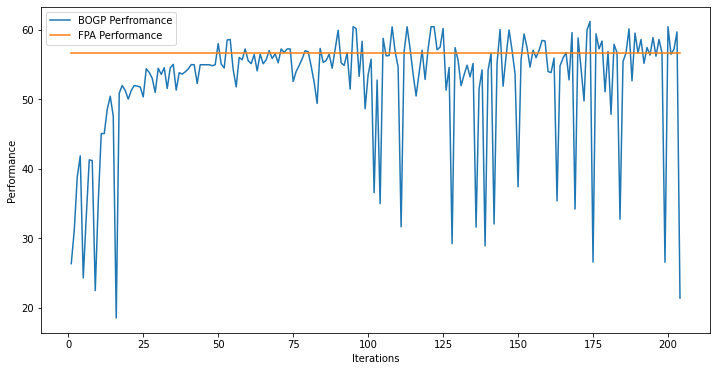

x_next is [ 29.99409431  29.98955176 -10.53052534  22.0818889   29.98962189
  29.94616867 -30.83782288  29.89661752  29.97130932   4.36383631
  28.10624019  29.78808242  -9.37445941  29.9964654   29.94166205
  29.98411214  29.94147222  29.98544797  29.9850054   29.97874305]
f()=55.080417, actual=55.567
61


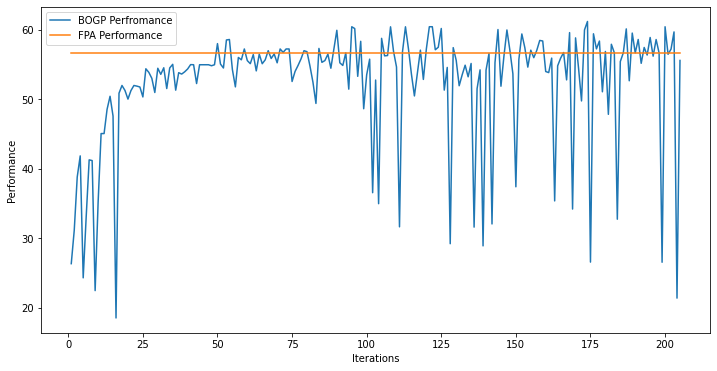

x_next is [ 29.93908927  29.97687082 -15.99882539   9.21894287  29.96953849
  29.95892278  29.98421189  29.99408735 -22.34249798  25.74332351
 -30.97161877 -30.97868204  29.93518601  29.98760656  29.97156054
  29.98596876  29.87459885  29.98550694  29.99552567  29.99468147]
f()=58.824752, actual=56.600
62


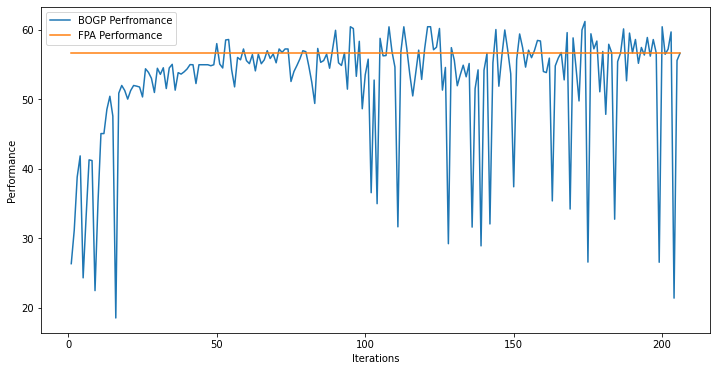

KeyboardInterrupt: ignored

In [17]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(200):
  x_next = opt_acquisition(X, y, model)

  np.save("/content/drive/MyDrive/trainingx_BOGP_EI.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP_EI.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP_EI.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)

  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()

pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

print("Power_configuration_BOGP is", X[ix])
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:])
pyplot.plot(np.arange(1,21),X_FPA[:])
pyplot.show()




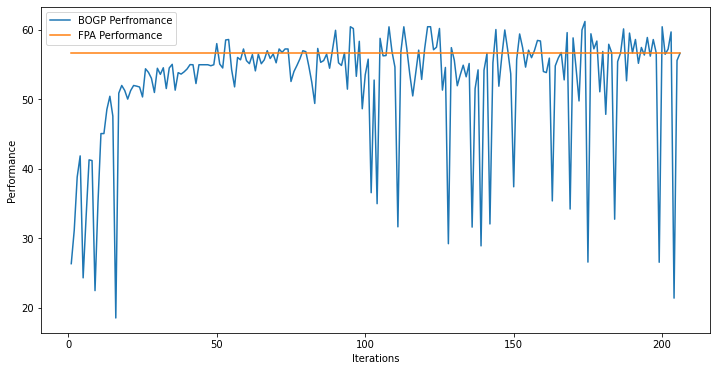

P_max = 30.000, Optimal_SE = 61.178
P_max = 30.000, Optimal_SE_FPA = 56.571


In [19]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

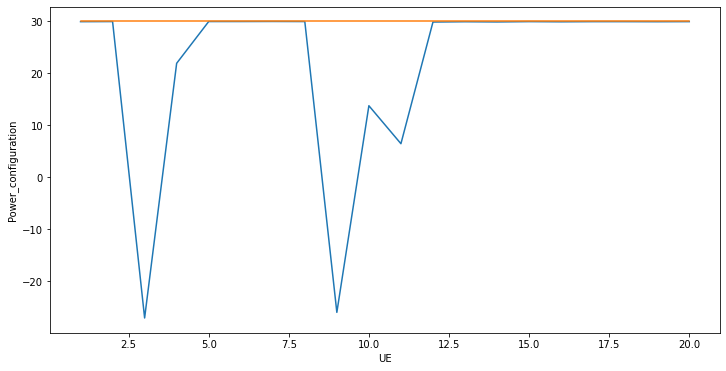

Power_configuration_BOGP is [ 29.96104764  29.98067502 -27.09746063  21.94441705  29.98542014
  29.98698711  29.99926116  29.98286014 -26.01765563  13.77444696
   6.46296549  29.89145147  29.94994344  29.91028705  29.97095938
  29.93565668  29.96628683  29.96569883  29.95105119  29.96811643]


In [23]:
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
plt.figure(figsize = (12, 6)) 
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:])
pyplot.plot(np.arange(1,21),X_FPA[:])
pyplot.show()
print("Power_configuration_BOGP is", X[ix])

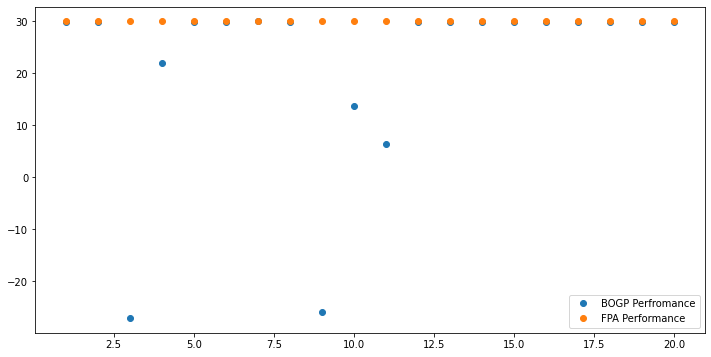

Power_configuration_BOGP is [ 29.96104764  29.98067502 -27.09746063  21.94441705  29.98542014
  29.98698711  29.99926116  29.98286014 -26.01765563  13.77444696
   6.46296549  29.89145147  29.94994344  29.91028705  29.97095938
  29.93565668  29.96628683  29.96569883  29.95105119  29.96811643]


In [21]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])